In [2]:
import sys
sys.path.append('..')
from PIL import Image
from os import listdir, path
from matplotlib import pyplot as plt

import torch

/local/omp/anaconda3/envs/cs503/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from models.model import Model as AutoLink
device = 'cuda'
from utils_.visualization import draw_kp_grid, get_part_color, denormalize

In [4]:
autolink = AutoLink.load_from_checkpoint(path.join("..", "checkpoints", "cars_multiview_test", "model.ckpt"))
autolink.to(device)

Model(
  (encoder): Encoder(
    (detector): Detector(
      (conv): Sequential(
        (0): ResBlock(
          (conv_res): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): Upsample(scale_factor=0.5, mode=bilinear)
            (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (net): Sequential(
            (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): Upsample(scale_factor=0.5, mode=bilinear)
            (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (3): LeakyReLU(negative_slope=0.2, inplace=True)
            (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (relu): LeakyReLU(negative_slope=0.2, inplace=True)
        )
        (1): ResBloc

In [5]:
data_root = "../cars/no_background_isnet/"
filename = 'tripod_seq_{:02d}_{:03d}.png'
all_files = sorted(listdir(data_root))
img = Image.open(path.join(data_root, filename.format(1, 1))).convert('RGB')

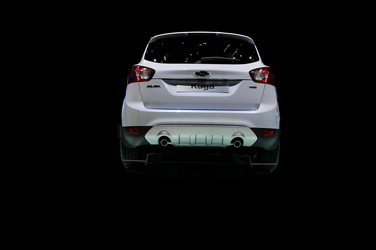

In [6]:
img

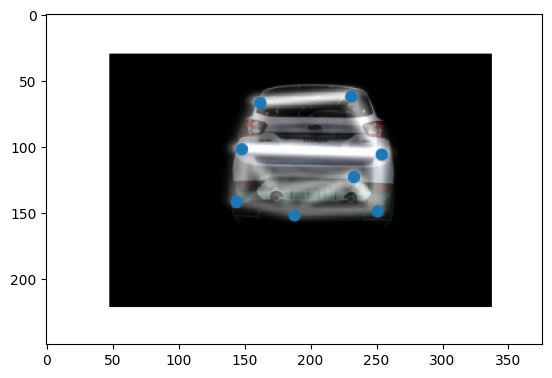

In [8]:
plt.imshow(autolink.forward_no_multiview(img))

In [21]:
import torch.nn.functional as F
from torchvision import transforms

In [35]:
transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [51]:
input_img = transform(img).unsqueeze(0).to(device)

In [58]:
output = autolink.encoder.detector(input_img)

In [48]:
def draw_kp_img(img, kp):
    kp_color = get_part_color(kp.shape[1])
    img = img.permute(0, 2, 3, 1).detach().cpu()
    kp = kp.detach().cpu()

    fig = plt.figure(figsize=(8, 8))
    sample = img[0]
    plt.axis('off')
    plt.imshow(sample, vmin=0, vmax=1)
    plt.scatter(kp[0, :, 1], kp[0, :, 0], c=kp_color, s=20, marker='+')

    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


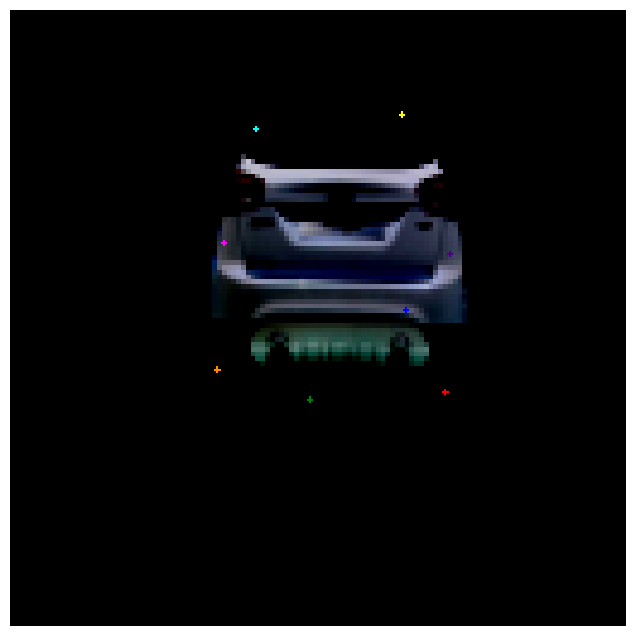

In [59]:
scaled_kp = output['keypoints'] * 128 / 2 + 128 / 2

draw_kp_img(input_img, scaled_kp)

In [61]:
edge_map = autolink.decoder.rasterize(output["keypoints"], output_size=64)

In [ ]:
bs = edge_map.shape[0]
edge_map = edge_map / (1e-8 + edge_map.reshape(bs, 1, -1).max(dim=2, keepdim=True)[0].reshape(bs, 1, 1, 1))
edge_map = torch.cat([edge_map] * 3, dim=1)
edge_map = F.interpolate(edge_map, size=(h, w), mode='bilinear', align_corners=False)
x = torch.clamp(edge_map + (x * 0.5 + 0.5)*0.5, min=0, max=1)
x = transforms.ToPILImage()(x[0].detach().cpu())

fig = plt.figure(figsize=(1, h/w), dpi=w)
fig.tight_layout(pad=0)
plt.axis('off')
plt.imshow(x)
kp = kp[0].detach().cpu() * 0.5 + 0.5
kp[:, 1] *= w
kp[:, 0] *= h
plt.scatter(kp[:, 1], kp[:, 0], s=min(w/h, min(1, h/w)), marker='o')
ncols, nrows = fig.canvas.get_width_height()
fig.canvas.draw()
plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(nrows, ncols, 3)
plt.close(fig)

In [44]:
edges

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0',
       grad_fn=<MaxBackward0>)